# Assessments across interventions

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../code')
from data_cleaning import gender_mapping

plt.style.use('tableau-colorblind10')
color='#702A7D'

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

In [3]:
query = """
WITH assessment_cat as (SELECT 
  a.person_id
  ,a.AssessmentID
  ,f.category
  ,f.subcategory
FROM
  `CB_2649.tbl_bmbc_Childrens_Social_Services_Assessments` a

LEFT JOIN `CB_2649.cb_FactorLookup` f
ON a.FactorID = f.FactorID)
SELECT ac.person_id
  ,STRING_AGG(distinct ac.category, ', ') AS all_categories
  ,p.gender_source_value as gender
FROM assessment_cat ac
LEFT JOIN yhcr-prd-bradfor-bia-core.CB_2649.person p
on ac.person_id = p.person_id
GROUP BY ac.person_id,p.gender_source_value;
"""

In [4]:
query_with_lsoa = """
WITH assessment_cat AS (
  SELECT 
    a.person_id,
    a.AssessmentID,
    a.StartDate,
    f.category,
    f.subcategory
  FROM
    `CB_2649.tbl_bmbc_Childrens_Social_Services_Assessments` a
  LEFT JOIN `CB_2649.cb_FactorLookup` f
    ON a.FactorID = f.FactorID
),

assessment_with_address AS (
  SELECT
    ac.person_id,
    ac.AssessmentID,
    ac.category,
    ac.subcategory,
    ac.StartDate,
    ah.SOA AS LSOA,
    ROW_NUMBER() OVER (
      PARTITION BY ac.person_id, ac.AssessmentID
      ORDER BY CAST(ah.DateEvent AS TIMESTAMP) DESC
    ) AS rank
  FROM assessment_cat ac
LEFT  JOIN `yhcr-prd-bradfor-bia-core.CB_2649.tbl_AddressHistory_New` ah
    ON ac.person_id = ah.person_id
    AND CAST(ah.DateEvent AS TIMESTAMP) <= CAST(ac.StartDate AS TIMESTAMP)
  WHERE ac.StartDate IS NOT NULL
)
SELECT 
  awa.person_id,
  STRING_AGG(DISTINCT awa.category, ', ') AS all_categories,
  p.gender_source_value AS gender,
  MAX(awa.LSOA) AS LSOA  -- Using MAX to get a single LSOA per person
FROM assessment_with_address awa
JOIN `yhcr-prd-bradfor-bia-core.CB_2649.person` p
  ON awa.person_id = p.person_id
WHERE awa.rank = 1  -- Only include the most recent address for each assessment
GROUP BY awa.person_id, p.gender_source_value;
"""

# Load Query into Pandas Dataframe

In [5]:
assessment = pandas_gbq.read_gbq(query)
assessment_with_lsoa = pandas_gbq.read_gbq(query_with_lsoa)

Downloading: 100%|██████████|
Downloading: 100%|██████████|


In [6]:
assessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5902 entries, 0 to 5901
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   person_id       5902 non-null   object
 1   all_categories  5902 non-null   object
 2   gender          5899 non-null   object
dtypes: object(3)
memory usage: 138.5+ KB


In [7]:
assessment.head()

,person_id,all_categories,gender
0,5CDE8C6A7B2CB16B6F943015A59FE11ACAB4BB7C1D1034...,"Socially Unacceptable Behaviour, Learning Disa...",1
1,963CC63AFC0B205718057BA30037DEB678B0654AD1DAE5...,Domestic Violence,2
2,97EBB86456C7D933726776B64BFD8976E5CDB2BD4AEBBB...,Domestic Violence,2
3,BC2476193F8D5F34C7F0CA982AAA1C82EE4342B8C717CE...,Domestic Violence,1
4,1659789959EE4F4432C98E7210073767DD1CBC91A7303E...,"Mental Health, Drug Misuse, Other",2


In [9]:
# Clean Gender column
gender_mapping(assessment, 'gender')

array([None, nan, 'Female', 'Male'], dtype=object)

In [10]:
# Clean the categories for consistency
assessment['all_categories'] = (assessment['all_categories']
                               .str.strip()
                               .str.lower()
                               .str.replace('\s*,\s*', ',', regex=True))

# Split and create dummy variables
category_dummies = assessment['all_categories'].str.get_dummies(sep=',')

# Now combine the original dataframe with the dummy variables
assessment_wide = pd.concat([assessment[['person_id', 'gender']], 
                             category_dummies], axis=1)

In [11]:
assessment_wide.columns

Index(['person_id', 'gender', 'abuse linked to faith or belief',
       'alcohol misuse', 'child criminal exploitation',
       'child sexual exploitation', 'domestic violence', 'drug misuse',
       'emotional abuse', 'female genital mutilation', 'gangs',
       'learning disability', 'mental health', 'missing', 'neglect', 'other',
       'physical abuse', 'physical disability', 'privately fostered',
       'self harm', 'sexual abuse', 'socially unacceptable behaviour',
       'trafficking', 'uasc', 'young carer'],
      dtype='object')

In [12]:
assessment_wide.head()

,person_id,gender,abuse linked to faith or belief,alcohol misuse,child criminal exploitation,child sexual exploitation,domestic violence,drug misuse,emotional abuse,female genital mutilation,...,other,physical abuse,physical disability,privately fostered,self harm,sexual abuse,socially unacceptable behaviour,trafficking,uasc,young carer
0,5CDE8C6A7B2CB16B6F943015A59FE11ACAB4BB7C1D1034...,None,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,963CC63AFC0B205718057BA30037DEB678B0654AD1DAE5...,None,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,97EBB86456C7D933726776B64BFD8976E5CDB2BD4AEBBB...,None,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BC2476193F8D5F34C7F0CA982AAA1C82EE4342B8C717CE...,None,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1659789959EE4F4432C98E7210073767DD1CBC91A7303E...,None,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [13]:
# Calculate patterns per case
reasons_per_case = assessment_wide.iloc[:, 2:].sum(axis=1)  # excluding id and gender column

# Calculate percentages and counts
total_cases = len(reasons_per_case)
single_reason_count = (reasons_per_case == 1).sum()
multiple_reasons_count = (reasons_per_case > 1).sum()

single_reason_percent = (single_reason_count / total_cases) * 100
multiple_reasons_percent = (multiple_reasons_count / total_cases) * 100

print("=== Entry Pattern Analysis ===")
print(f"Total number of cases: {total_cases}")
print(f"Cases with single reason: {single_reason_count} ({single_reason_percent:.1f}%)")
print(f"Cases with multiple reasons: {multiple_reasons_count} ({multiple_reasons_percent:.1f}%)")
print(f"Average number of reasons per case: {reasons_per_case.mean():.2f}")

# Further breakdown
print("\nDistribution of number of reasons:")
reason_distribution = reasons_per_case.value_counts().sort_index()
for n_reasons, count in reason_distribution.items():
    percentage = (count / total_cases) * 100
    print(f"{n_reasons} reason(s): {count} cases ({percentage:.1f}%)")

=== Entry Pattern Analysis ===
Total number of cases: 5902
Cases with single reason: 796 (13.5%)
Cases with multiple reasons: 5106 (86.5%)
Average number of reasons per case: 4.15

Distribution of number of reasons:
1 reason(s): 796 cases (13.5%)
2 reason(s): 1038 cases (17.6%)
3 reason(s): 917 cases (15.5%)
4 reason(s): 840 cases (14.2%)
5 reason(s): 743 cases (12.6%)
6 reason(s): 596 cases (10.1%)
7 reason(s): 377 cases (6.4%)
8 reason(s): 255 cases (4.3%)
9 reason(s): 123 cases (2.1%)
10 reason(s): 76 cases (1.3%)
11 reason(s): 72 cases (1.2%)
12 reason(s): 28 cases (0.5%)
13 reason(s): 21 cases (0.4%)
14 reason(s): 17 cases (0.3%)
15 reason(s): 1 cases (0.0%)
16 reason(s): 2 cases (0.0%)


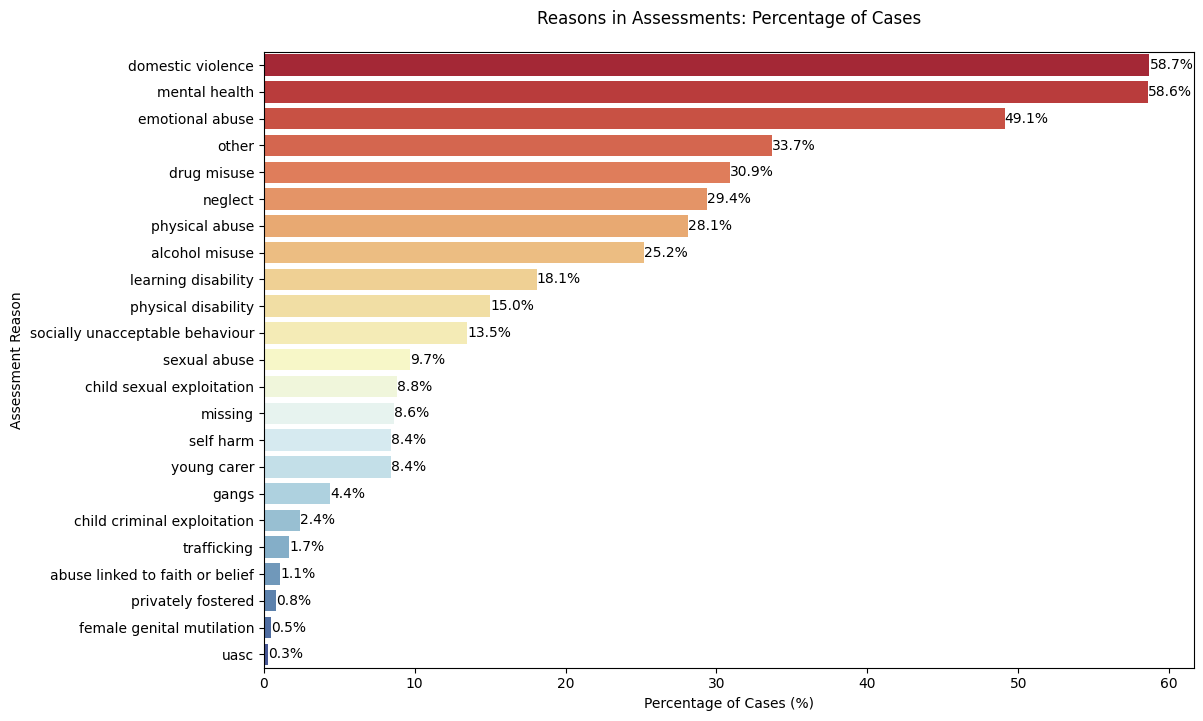

In [14]:
# Sum up each category column and sort in descending order
category_counts = assessment_wide.iloc[:, 2:].sum().sort_values(ascending=False)

# Calculate percentages
category_percentages = (category_counts / total_cases * 100)

# Combine counts and percentages in a readable format
category_analysis = pd.DataFrame({
    'Count': category_counts,
    'Percentage': category_percentages
}).round(1)  # Round percentages to 1 decimal place

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(
    x=category_analysis['Percentage'],
    y=category_analysis.index,
    palette='RdYlBu'  # Color palette often used in social services reporting
)

plt.title('Reasons in Assessments: Percentage of Cases', pad=20)
plt.xlabel('Percentage of Cases (%)')
plt.ylabel('Assessment Reason')

# Add percentage labels on bars
for i, v in enumerate(category_analysis['Percentage']):
    plt.text(v, i, f'{v}%', va='center')

In [15]:
# Find most common reason combinations
# Create co-occurrence matrix
co_occurrence = assessment_wide.iloc[:, 2:].T.dot(assessment_wide.iloc[:, 2:])

# Find most common combinations
combinations = []
for i in range(len(co_occurrence)):
    for j in range(i+1, len(co_occurrence)):
        combinations.append({
            'reason1': co_occurrence.index[i],
            'reason2': co_occurrence.index[j],
            'count': co_occurrence.iloc[i,j]
        })

combinations_df = pd.DataFrame(combinations)
print("\n=== Most Common Reason Combinations ===")
print(combinations_df.sort_values('count', ascending=False).head(10).reset_index(drop=True))


=== Most Common Reason Combinations ===
             reason1            reason2  count
0  domestic violence      mental health   2220
1  domestic violence    emotional abuse   2183
2    emotional abuse      mental health   2011
3    emotional abuse     physical abuse   1379
4  domestic violence        drug misuse   1340
5        drug misuse      mental health   1322
6    emotional abuse            neglect   1271
7  domestic violence     physical abuse   1256
8      mental health            neglect   1222
9     alcohol misuse  domestic violence   1186


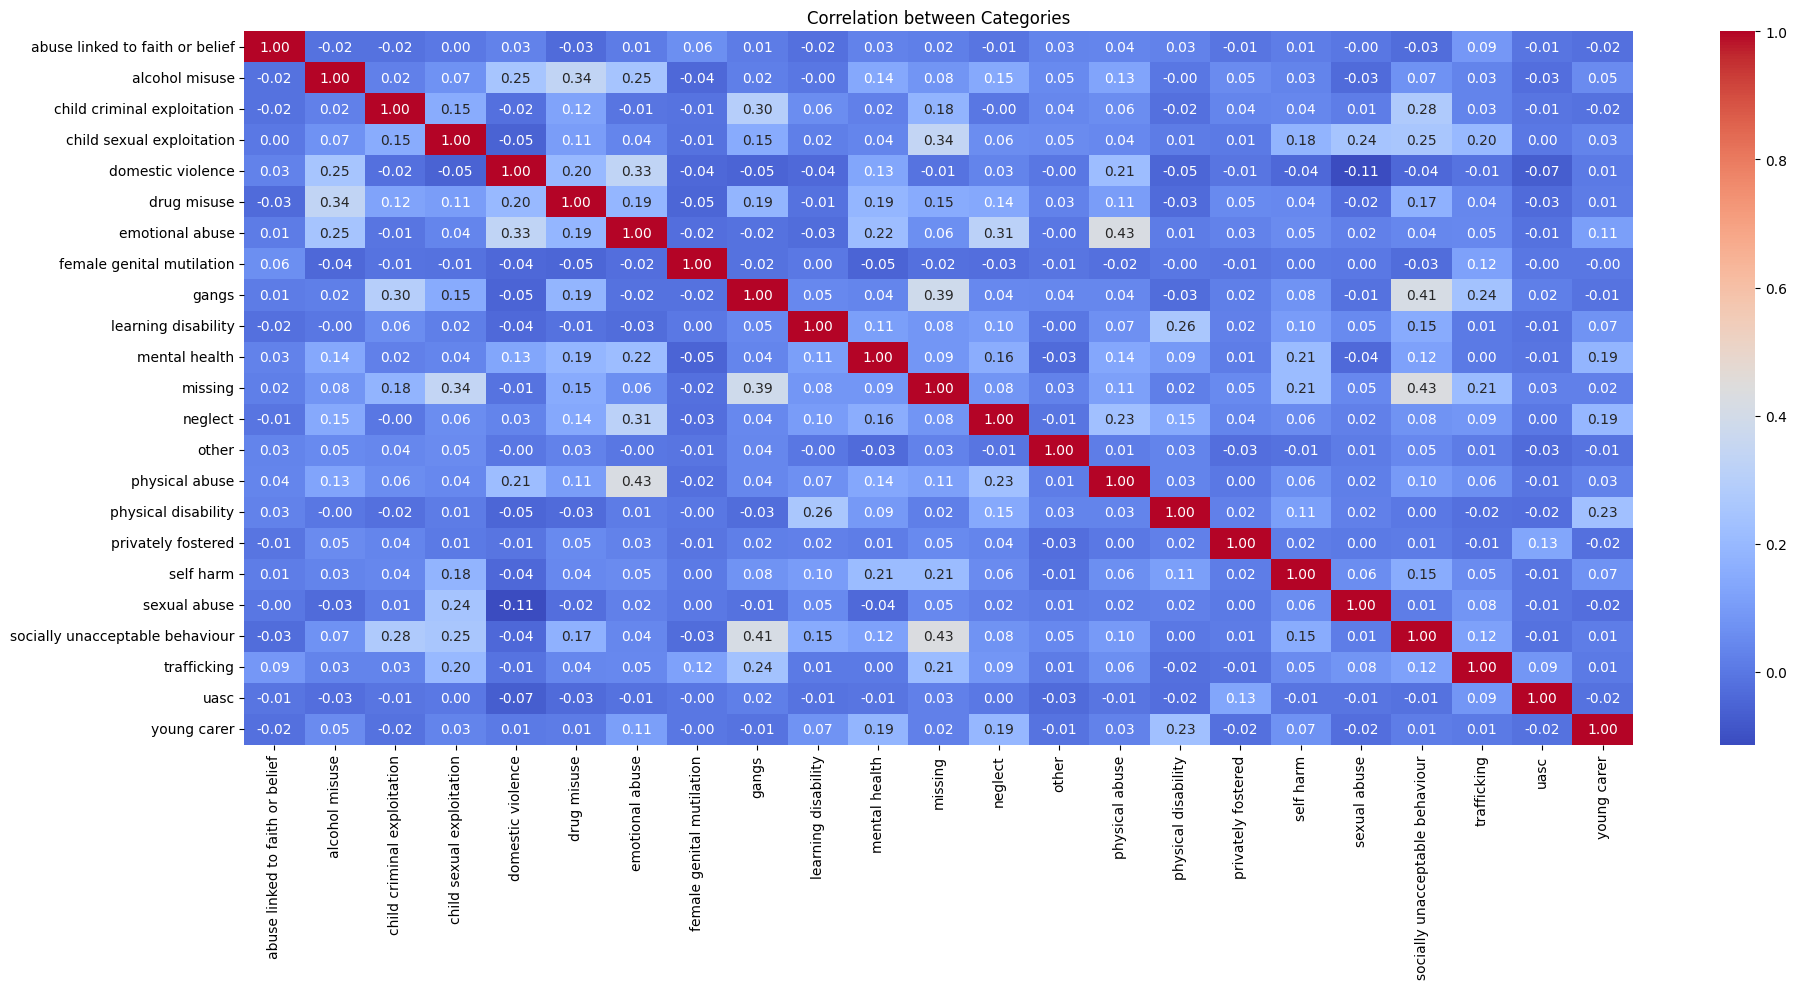

In [16]:
# Correlation between categories
plt.figure(figsize=(20,10))
correlations = assessment_wide.iloc[:, 2:].corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Categories")
plt.tight_layout()
plt.show()